In [5]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.1 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_json('/content/final_data_detik.json')

with open('/content/tokenizer_keras.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('/content/label_encoder.pickle', 'rb') as handle:
    le = pickle.load(handle)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
MAX_LEN = 100
VOCAB_SIZE = len(tokenizer.word_index) + 1
num_classes = len(le.classes_)

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
Y_labels = tf.keras.utils.to_categorical(df['label'], num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    Y_labels,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"Setup Selesai.")
print(f"VOCAB_SIZE: {VOCAB_SIZE}")
print(f"Data Train: {X_train.shape}")

Setup Selesai.
VOCAB_SIZE: 40938
Data Train: (7200, 100)


In [9]:
from sklearn.metrics import accuracy_score, f1_score

def base_model():
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_LEN))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = base_model()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)

f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Akurasi Base Model: {accuracy * 100:.2f}%")
print(f"F1-Score Base Model: {f1:.2f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - accuracy: 0.2273 - loss: 2.0478 - val_accuracy: 0.6812 - val_loss: 0.9516
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7250 - loss: 0.8238 - val_accuracy: 0.8604 - val_loss: 0.5038
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.8964 - loss: 0.3722 - val_accuracy: 0.8931 - val_loss: 0.4083
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.9539 - loss: 0.1938 - val_accuracy: 0.8986 - val_loss: 0.4342
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.9821 - loss: 0.0898 - val_accuracy: 0.9021 - val_loss: 0.4480
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.9825 - loss: 0.0752 - val_accuracy: 0.8965 - val_loss: 0.4945
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.9887 - loss: 0.0498 - val_accuracy: 0.9007 - val_loss: 0.5219
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.9928 - loss: 0

In [ ]:
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

def build_lstm_extensive_grid(hp):
    model = Sequential()

    embed_dim = hp.Choice('embedding_dim', values=[100])
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embed_dim, input_length=MAX_LEN))

    num_layers = hp.Choice('num_layers', values=[1, 2])

    for i in range(num_layers):
        return_seq = True

        units = hp.Choice(f'units_layer_{i}', values=[64, 128])

        l2_rate = hp.Choice(f'l2_rate_{i}', values=[1e-4, 1e-3])

        model.add(Bidirectional(LSTM(
            units=units,
            return_sequences=return_seq,
            kernel_regularizer=l2(l2_rate)
        )))

        dropout = hp.Choice(f'dropout_{i}', values=[0.3, 0.4, 0.5])
        model.add(Dropout(dropout))

    model.add(GlobalMaxPool1D())

    use_dense = hp.Choice('use_dense_layer', values=[False, True])
    if use_dense:
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
        model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    lr = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner_extensive = kt.GridSearch(
    hypermodel=build_lstm_extensive_grid,
    objective='val_accuracy',
    max_trials=None,
    directory='tuning_results',
    project_name='lstm_extensive_search_v1'
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

tuner_extensive.search_space_summary()

Search space summary
Default search space size: 7
embedding_dim (Choice)
{'default': 100, 'conditions': [], 'values': [100], 'ordered': True}
num_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
units_layer_0 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
l2_rate_0 (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001], 'ordered': True}
dropout_0 (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
use_dense_layer (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}


I0000 00:00:1765278056.267655      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765278056.268241      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
tuner_extensive.search(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

Trial 400 Complete [00h 00m 33s]
val_accuracy: 0.8986111283302307

Best val_accuracy So Far: 0.925000011920929
Total elapsed time: 04h 25m 44s

Search: Running Trial #401

Value             |Best Value So Far |Hyperparameter
100               |100               |embedding_dim
2                 |2                 |num_layers
64                |64                |units_layer_0
0.001             |0.0001            |l2_rate_0
0.4               |0.4               |dropout_0
1                 |0                 |use_dense_layer
0.001             |0.001             |learning_rate
64                |64                |units_layer_1
0.001             |0.0001            |l2_rate_1
0.4               |0.3               |dropout_1

Epoch 1/10
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2753 - loss: 2.2021

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-pa

OSError: [Errno 28] Can't close file (file write failed: time = Tue Dec  9 15:26:55 2025
, filename = 'tuning_results/lstm_extensive_search_v1/trial_0400/checkpoint.weights.h5', file descriptor = 55, errno = 28, error message = 'No space left on device', buf = 0x28a3c390, total write size = 2048, bytes this sub-write = 2048, offset = 4096)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 223, in h5py._objects.ObjectID.__dealloc__
OSError: [Errno 28] Can't close file (file write failed: time = Tue Dec  9 15:26:55 2025
, filename = 'tuning_results/lstm_extensive_search_v1/trial_0400/checkpoint.weights.h5', file descriptor = 55, errno = 28, error message = 'No space left on device', buf = 0x28a3c390, total write size = 2048, bytes this sub-write = 2048, offset = 4096)


ResourceExhaustedError: tuning_results/lstm_extensive_search_v1/trial_0400/trial.json; No space left on device

In [ ]:
best_hps = tuner_extensive.get_best_hyperparameters(num_trials=1)[0]

print("=== BEST HYPERPARAMETERS FOUND ===")
print(f"Embedding Dim   : {best_hps.get('embedding_dim')}")
print(f"Num Layers      : {best_hps.get('num_layers')}")
print(f"Learning Rate   : {best_hps.get('learning_rate')}")
print(f"Use Dense Layer : {best_hps.get('use_dense_layer')}")

for i in range(best_hps.get('num_layers')):
    print(f"--- Layer {i+1} ---")
    print(f"   Units   : {best_hps.get(f'units_layer_{i}')}")
    print(f"   Dropout : {best_hps.get(f'dropout_{i}')}")
    print(f"   L2 Rate : {best_hps.get(f'l2_rate_{i}')}")

=== BEST HYPERPARAMETERS FOUND ===
Embedding Dim   : 100
Num Layers      : 2
Learning Rate   : 0.001
Use Dense Layer : 0
--- Layer 1 ---
   Units   : 64
   Dropout : 0.4
   L2 Rate : 0.0001
--- Layer 2 ---
   Units   : 64
   Dropout : 0.3
   L2 Rate : 0.0001


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1_scores = []
y_indices = np.argmax(Y_labels, axis=1)

print(f"\n=== MEMULAI {k}-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_padded, y_indices)):
    print(f"\nTraining Fold {fold+1}/{k}...")

    X_train_fold, X_val_fold = X_padded[train_idx], X_padded[val_idx]
    y_train_fold, y_val_fold = Y_labels[train_idx], Y_labels[val_idx]

    model_fold = tuner_extensive.hypermodel.build(best_hps)

    model_fold.fit(
        X_train_fold, y_train_fold,
        epochs=15,
        batch_size=32,
        verbose=0
    )

    y_pred_prob = model_fold.predict(X_val_fold, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val_fold, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)
    print(f"--> Fold {fold+1} Accuracy: {acc:.4f}")

print("\n=== HASIL RATA-RATA K-FOLD ===")
print(f"Average Accuracy : {np.mean(fold_accuracies):.2%}")
print(f"Average F1-Score : {np.mean(fold_f1_scores):.4f}")


=== MEMULAI 5-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===

Training Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--> Fold 1 Accuracy: 0.9289

Training Fold 2/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--> Fold 2 Accuracy: 0.9233

Training Fold 3/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--> Fold 3 Accuracy: 0.9294

Training Fold 4/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--> Fold 4 Accuracy: 0.9289

Training Fold 5/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--> Fold 5 Accuracy: 0.9278

=== HASIL RATA-RATA K-FOLD ===
Average Accuracy : 92.77%
Average F1-Score : 0.9271



=== MEMULAI 5-FOLD CROSS VALIDATION DENGAN MODEL TERBAIK ===

Evaluating Fold 1/5...
--> Fold 1 Accuracy: 0.9850

Evaluating Fold 2/5...
--> Fold 2 Accuracy: 0.9911

Evaluating Fold 3/5...
--> Fold 3 Accuracy: 0.9850

Evaluating Fold 4/5...
--> Fold 4 Accuracy: 0.9889

Evaluating Fold 5/5...
--> Fold 5 Accuracy: 0.9844

=== HASIL RATA-RATA K-FOLD ===
Average Accuracy : 98.69%
Average F1-Score : 0.9869

=== EVALUASI FINAL MODEL ===
Final Model Accuracy: 93.44%
Final Model F1-Score: 0.9341


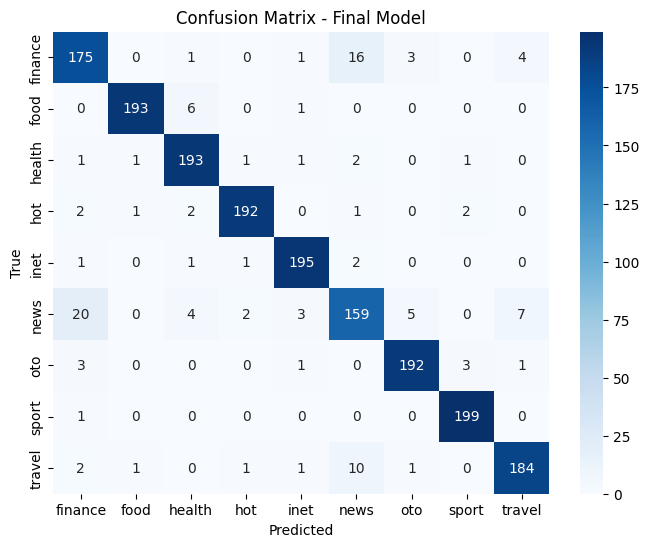

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1_scores = []
y_indices = np.argmax(Y_labels, axis=1)

model_path = '/content/best_lstm_model_final.h5'
model_saved = load_model(model_path)

print(f"\n=== MEMULAI {k}-FOLD CROSS VALIDATION DENGAN MODEL TERBAIK ===")

best_model = model_saved

for fold, (train_idx, val_idx) in enumerate(kf.split(X_padded, y_indices)):
    print(f"\nEvaluating Fold {fold+1}/{k}...")

    X_train_fold, X_val_fold = X_padded[train_idx], X_padded[val_idx]
    y_train_fold, y_val_fold = Y_labels[train_idx], Y_labels[val_idx]

    X_train_fold = np.array(X_train_fold)
    X_val_fold = np.array(X_val_fold)

    model_fold = model_saved

    y_pred_prob = model_fold.predict(X_val_fold, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val_fold, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)

    print(f"--> Fold {fold+1} Accuracy: {acc:.4f}")

print("\n=== HASIL RATA-RATA K-FOLD ===")
print(f"Average Accuracy : {np.mean(fold_accuracies):.2%}")
print(f"Average F1-Score : {np.mean(fold_f1_scores):.4f}")

print("\n=== EVALUASI FINAL MODEL ===")

y_pred_final = best_model.predict(X_test, verbose=0)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy_final = accuracy_score(y_true_classes, y_pred_classes_final)
f1_final = f1_score(y_true_classes, y_pred_classes_final, average='weighted')

print(f"Final Model Accuracy: {accuracy_final * 100:.2f}%")
print(f"Final Model F1-Score: {f1_final:.4f}")

cm_final = confusion_matrix(y_true_classes, y_pred_classes_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Final Model")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model_final = tuner_extensive.hypermodel.build(best_hps)

history_final = model_final.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[stop_early],
    verbose=1
)

model_final.save('best_lstm_model_final.h5')
print("\n[SUKSES] Model 'best_lstm_model_final.h5' berhasil disimpan!")

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4069 - loss: 1.6574 - val_accuracy: 0.8439 - val_loss: 0.5885
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9189 - loss: 0.3039 - val_accuracy: 0.9072 - val_loss: 0.3679
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9712 - loss: 0.1399 - val_accuracy: 0.9278 - val_loss: 0.2890
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9886 - loss: 0.0790 - val_accuracy: 0.9100 - val_loss: 0.3381
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9915 - loss: 0.0651 - val_accuracy: 0.9272 - val_loss: 0.2770
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9964 - loss: 0.0451 - val_accuracy: 0.9211 - val_loss: 0.3080
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9909 - loss: 0.0545 - val_accuracy: 0.9278 - val_loss: 0.2812
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9892 - loss: 0.0667 - val_accu


[SUKSES] Model 'best_lstm_model_final.h5' berhasil disimpan!


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

print("[INFO] Melakukan prediksi pada data test...")
y_pred_probs = model_final.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== EVALUASI PERFORMA MODEL LSTM FINAL ===")
print(f"Akurasi Global: {accuracy_score(y_true, y_pred):.2%}")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=le.classes_))

[INFO] Melakukan prediksi pada data test...

=== EVALUASI PERFORMA MODEL LSTM FINAL ===
Akurasi Global: 93.44%
------------------------------------------------------------
              precision    recall  f1-score   support

     finance       0.85      0.88      0.86       200
        food       0.98      0.96      0.97       200
      health       0.93      0.96      0.95       200
         hot       0.97      0.96      0.97       200
        inet       0.96      0.97      0.97       200
        news       0.84      0.80      0.82       200
         oto       0.96      0.96      0.96       200
       sport       0.97      0.99      0.98       200
      travel       0.94      0.92      0.93       200

    accuracy                           0.93      1800
   macro avg       0.93      0.93      0.93      1800
weighted avg       0.93      0.93      0.93      1800



In [ ]:
model_final.save('best_lstm_model_final.h5')

print("Model berhasil disimpan sebagai 'best_lstm_model_final.h5'")

Model berhasil disimpan sebagai 'best_lstm_model_final.h5'


In [ ]:
from IPython.display import FileLink

model_filename = 'best_lstm_model_final.h5'
model_final.save(model_filename)
print(f" Model berhasil dibuat di server Kaggle: {model_filename}")

print("Klik link di bawah ini untuk menyimpan ke Laptop:")
display(FileLink(model_filename))

 Model berhasil dibuat di server Kaggle: best_lstm_model_final.h5
Klik link di bawah ini untuk menyimpan ke Laptop:


/kaggle/working/best_lstm_model_final.h5

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import tensorflow as tf

custom_objects = {
    'InputLayer': tf.keras.layers.Input,
}

model = load_model('best_lstm_model_final.h5', custom_objects=custom_objects)

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Akurasi Model: {accuracy:.4f}")
print(f"F1-Score Model: {f1:.4f}")


TypeError: Error when deserializing class 'Embedding' using config={'name': 'embedding_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 40938, 'output_dim': 100, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}.

Exception encountered: Unknown dtype policy: 'DTypePolicy'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

Gated Recurrent United

Pelatihan Awal dengan Best Guess

In [ ]:
def build_best_gru_model(params, vocab_size, embedding_dim, max_len, num_classes):
    """Membangun model GRU dengan hyperparameter terbaik dari Random Search."""

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))

    for i in range(params['n_gru_layers']):
        return_seq = (i < params['n_gru_layers'] - 1)
        model.add(GRU(params['gru_units'], return_sequences=return_seq))

    model.add(Dropout(params['dropout_rate']))

    for i in range(params['n_dense_layers']):
        model.add(Dense(params['dense_units'], activation=params['dense_activation']))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(num_classes, activation='softmax'))

    if params['optimizer_name'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer_name'] == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
    elif params['optimizer_name'] == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

In [ ]:

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
from optuna.samplers import RandomSampler
import warnings
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

print("--- Memuat Data dan Preprocessing ---")

DATA_PATH = '/content/final_data_detik.json'
TOKENIZER_PATH = '/content/tokenizer_keras.pickle'
LABEL_ENCODER_PATH = '/content/label_encoder.pickle'

try:

    df = pd.read_json(DATA_PATH)
    print(f"Data berhasil dimuat dari {DATA_PATH} (Format Standar).")
except ValueError:
    try:

        df = pd.read_json(DATA_PATH, lines=True)
        print(f"Data berhasil dimuat dari {DATA_PATH} (Format JSON Lines).")
    except Exception as e:
        print(f"Error fatal saat memuat data JSON: {e}")
        exit()


try:
    with open(TOKENIZER_PATH, 'rb') as handle:
        tokenizer = pickle.load(handle)
    with open(LABEL_ENCODER_PATH, 'rb') as handle:
        le = pickle.load(handle)
    print("Tokenizer dan Label Encoder berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File Tokenizer/Label Encoder tidak ditemukan. Pastikan path sudah benar: {e}")
    exit()

num_classes = len(le.classes_)
MAX_LEN = 100
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index) + 1
N_SPLITS = 3
EPOCHS = 5
N_TRIALS = 10

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
Y_labels = tf.keras.utils.to_categorical(df['label'], num_classes)
Y_int = df['label'].values
EPOCHS = 5
k = 5

BEST_PARAMS = {
    'n_gru_layers': 3,
    'gru_units': 32,
    'dropout_rate': 0.1,
    'n_dense_layers': 0,
    'learning_rate': 0.001,
    'batch_size': 32,
    'dense_activation' : 'relu',
    'optimizer_name': 'Adam'
}

print("--- 0. Memisahkan Data menjadi Train/Validation (80%) dan Test Set (20%) ---")

X_train_val, X_test, Y_train_val, Y_test, Y_int_train_val, Y_int_test = train_test_split(
    X_padded, Y_labels, Y_int,
    test_size=0.2,
    random_state=42,
    stratify=Y_int
)

print(f"Total Sampel Uji (Test Set): {len(X_test)}")
print(f"Total Sampel Latih/Val (Train/Val Set): {len(X_train_val)}")
print("-------------------------------------------------------------------------")



kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1_scores = []

y_indices_train_val = Y_int_train_val

print(f"\n=== 1. MEMULAI {k}-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_indices_train_val)):
    print(f"\nTraining Fold {fold+1}/{k}...")

    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    model_fold = build_best_gru_model(BEST_PARAMS, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, num_classes)

    model_fold.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BEST_PARAMS['batch_size'],
        verbose=0
    )

    y_pred_prob = model_fold.predict(X_val_fold, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val_fold, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)
    print(f"--> Fold {fold+1} Accuracy: {acc:.4f}")

print("\n=== HASIL RATA-RATA K-FOLD ===")
print(f"Average Accuracy : {np.mean(fold_accuracies):.2%} (+/- {np.std(fold_accuracies):.2%})")
print(f"Average F1-Score : {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print("-------------------------------------------------------------------------")



print("\n--- 2. Melatih Model Final dengan Semua Data Train/Val (80%) ---")

final_model = build_best_gru_model(BEST_PARAMS, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, num_classes)

final_model.fit(
    X_train_val, Y_train_val,
    epochs=EPOCHS,
    batch_size=BEST_PARAMS['batch_size'],
    verbose=1
)
print("Pelatihan Model Final Selesai.")
print("-------------------------------------------------------------------------")


print("\n--- 3. EVALUASI AKHIR PADA DATA UJI (TEST SET) ---")

Y_pred_proba = final_model.predict(X_test)
Y_pred_int = np.argmax(Y_pred_proba, axis=1)
Y_true_int = np.argmax(Y_test, axis=1)

test_accuracy = accuracy_score(Y_true_int, Y_pred_int)

print(f"Akurasi Data Uji (Test Set): {test_accuracy:.4f}")
print("\n--- Laporan Klasifikasi Data Uji (Test Set) ---")
print(classification_report(Y_true_int, Y_pred_int))
print("------------------------------------------------")

--- Memuat Data dan Preprocessing ---
Data berhasil dimuat dari /content/final_data_detik.json (Format Standar).
Tokenizer dan Label Encoder berhasil dimuat.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


--- 0. Memisahkan Data menjadi Train/Validation (80%) dan Test Set (20%) ---
Total Sampel Uji (Test Set): 1800
Total Sampel Latih/Val (Train/Val Set): 7200
-------------------------------------------------------------------------

=== 1. MEMULAI 5-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===

Training Fold 1/5...
--> Fold 1 Accuracy: 0.8562

Training Fold 2/5...
--> Fold 2 Accuracy: 0.8660

Training Fold 3/5...
--> Fold 3 Accuracy: 0.8326

Training Fold 4/5...
--> Fold 4 Accuracy: 0.8507

Training Fold 5/5...
--> Fold 5 Accuracy: 0.8701

=== HASIL RATA-RATA K-FOLD ===
Average Accuracy : 85.51% (+/- 1.32%)
Average F1-Score : 0.8534 (+/- 0.0134)
-------------------------------------------------------------------------

--- 2. Melatih Model Final dengan Semua Data Train/Val (80%) ---
Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.2281 - loss: 1.9831
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 215ms/step - accuracy: 0.7636 - loss: 0.7465
Epoch 3/5
225/225 ━━━━━━━━

Pelatihan model menggunakan hyperparameter tuning dengan random search.

In [ ]:

import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
from optuna.samplers import RandomSampler
import warnings
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

print("--- Memuat Data dan Preprocessing ---")

DATA_PATH = '/content/final_data_detik.json'
TOKENIZER_PATH = '/content/tokenizer_keras.pickle'
LABEL_ENCODER_PATH = '/content/label_encoder.pickle'

try:

    df = pd.read_json(DATA_PATH)
    print(f"Data berhasil dimuat dari {DATA_PATH} (Format Standar).")
except ValueError:
    try:

        df = pd.read_json(DATA_PATH, lines=True)
        print(f"Data berhasil dimuat dari {DATA_PATH} (Format JSON Lines).")
    except Exception as e:
        print(f"Error fatal saat memuat data JSON: {e}")
        exit()

try:
    with open(TOKENIZER_PATH, 'rb') as handle:
        tokenizer = pickle.load(handle)
    with open(LABEL_ENCODER_PATH, 'rb') as handle:
        le = pickle.load(handle)
    print("Tokenizer dan Label Encoder berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File Tokenizer/Label Encoder tidak ditemukan. Pastikan path sudah benar: {e}")
    exit()


NUM_CLASSES = len(le.classes_)
MAX_LEN = 100
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index) + 1
N_SPLITS = 3
EPOCHS = 5
N_TRIALS = 10

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
Y_labels = tf.keras.utils.to_categorical(df['label'], NUM_CLASSES)
Y_int = df['label'].values

GRU_UNITS_SPACE = [16, 32, 64, 128]
DROPOUT_RATE_SPACE = [0.1, 0.2, 0.3, 0.4, 0.5]
LEARNING_RATE_SPACE = [0.0001, 0.001, 0.01, 0.1]
BATCH_SIZE_SPACE = [16, 32, 64, 128]
ACTIVATION_DENSE_SPACE = ['sigmoid', 'linear', 'relu']
OPTIMIZER_SPACE = ['Adam', 'SGD', 'RMSprop']

def create_gru_model(trial, vocab_size, embedding_dim, max_len, num_classes):
    """Membangun model GRU berdasarkan hyperparameter dari Optuna Random Search."""
    n_gru_layers = trial.suggest_int('n_gru_layers', 1, 3)
    gru_units = trial.suggest_categorical('gru_units', GRU_UNITS_SPACE)
    dropout_rate = trial.suggest_categorical('dropout_rate', DROPOUT_RATE_SPACE)
    n_dense_layers = trial.suggest_int('n_dense_layers', 0, 2)
    learning_rate = trial.suggest_categorical('learning_rate', LEARNING_RATE_SPACE)
    dense_activation = trial.suggest_categorical('dense_activation', ACTIVATION_DENSE_SPACE)
    optimizer_name = trial.suggest_categorical('optimizer_name', OPTIMIZER_SPACE)

    dense_units = 0
    if n_dense_layers > 0:
        dense_units = trial.suggest_categorical('dense_units', GRU_UNITS_SPACE)

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))

    # GRU Layers
    for i in range(n_gru_layers):
        return_seq = (i < n_gru_layers - 1)
        model.add(GRU(gru_units, return_sequences=return_seq))

    model.add(Dropout(dropout_rate))

    # Dense Hidden Layers
    for i in range(n_dense_layers):
        model.add(Dense(dense_units, activation=dense_activation))
        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Kompilasi
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        # Fallback
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

def objective_random_search(trial, X_train, Y_train, X_val, Y_val):
    """Fungsi objektif yang dioptimalkan oleh Optuna Random Search."""

    batch_size = trial.suggest_categorical('batch_size', BATCH_SIZE_SPACE)

    model = create_gru_model(trial, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, NUM_CLASSES)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,
        batch_size=batch_size,
        verbose=0
    )

    val_accuracy = history.history['val_accuracy'][-1]

    tf.keras.backend.clear_session()

    return val_accuracy

# RANDOM SEARCH
X_train_val, X_test, Y_train_val, Y_test, Y_int_train_val, Y_int_test = train_test_split(
    X_padded, Y_labels, Y_int, test_size=0.2, random_state=42, stratify=Y_int
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=0.25, random_state=42, stratify=np.argmax(Y_train_val, axis=1)
)


print("\n--- Memulai Random Search Optuna ---")
sampler = RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

objective_optuna = lambda trial: objective_random_search(trial, X_train, Y_train, X_val, Y_val)

try:
    study.optimize(objective_optuna, n_trials=N_TRIALS, show_progress_bar=True)

    BEST_PARAMS = study.best_params
    print("\n--- Hasil Terbaik Random Search ---")
    print(f"Akurasi Validasi Terbaik: {study.best_value:.4f}")
    print("Hyperparameters Terbaik:")
    print(BEST_PARAMS)
    print("-----------------------------------")
except NameError:
    print("Error: Optuna belum terinstal atau diimpor. Pastikan Anda menjalankan '!pip install optuna' dan 'import optuna'.")

--- Memuat Data dan Preprocessing ---
Data berhasil dimuat dari /content/final_data_detik.json (Format Standar).
Tokenizer dan Label Encoder berhasil dimuat.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
[I 2025-12-15 12:28:49,442] A new study created in memory with name: no-name-e6737e18-ebbc-4253-bd8c-e8c418a7b12e



--- Memulai Random Search Optuna ---


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-15 12:30:33,583] Trial 0 finished with value: 0.9166666865348816 and parameters: {'batch_size': 32, 'n_gru_layers': 1, 'gru_units': 64, 'dropout_rate': 0.3, 'n_dense_layers': 0, 'learning_rate': 0.01, 'dense_activation': 'linear', 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: 0.9166666865348816.
[I 2025-12-15 12:33:46,373] Trial 1 finished with value: 0.20888888835906982 and parameters: {'batch_size': 16, 'n_gru_layers': 1, 'gru_units': 128, 'dropout_rate': 0.1, 'n_dense_layers': 1, 'learning_rate': 0.1, 'dense_activation': 'linear', 'optimizer_name': 'SGD', 'dense_units': 16}. Best is trial 0 with value: 0.9166666865348816.
[I 2025-12-15 12:36:36,738] Trial 2 finished with value: 0.5350000262260437 and parameters: {'batch_size': 32, 'n_gru_layers': 1, 'gru_units': 128, 'dropout_rate': 0.5, 'n_dense_layers': 0, 'learning_rate': 0.0001, 'dense_activation': 'sigmoid', 'optimizer_name': 'Adam'}. Best is trial 0 with value: 0.9166666865348816.
[I 2025-12-15 12:38:26,

In [ ]:
def build_best_gru_model(params, vocab_size, embedding_dim, max_len, num_classes):
    """Membangun model GRU dengan hyperparameter terbaik dari Random Search."""

    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim))

    # GRU Layers
    for i in range(params['n_gru_layers']):
        return_seq = (i < params['n_gru_layers'] - 1)
        model.add(GRU(params['gru_units'], return_sequences=return_seq))

    model.add(Dropout(params['dropout_rate']))

    # Dense Hidden Layers
    for i in range(params['n_dense_layers']):
        model.add(Dense(params['dense_units'], activation=params['dense_activation']))
        model.add(Dropout(params['dropout_rate']))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Kompilasi
    if params['optimizer_name'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer_name'] == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
    elif params['optimizer_name'] == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

In [ ]:

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
from optuna.samplers import RandomSampler
import warnings
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

print("--- Memuat Data dan Preprocessing ---")

DATA_PATH = '/content/final_data_detik.json'
TOKENIZER_PATH = '/content/tokenizer_keras.pickle'
LABEL_ENCODER_PATH = '/content/label_encoder.pickle'

try:

    df = pd.read_json(DATA_PATH)
    print(f"Data berhasil dimuat dari {DATA_PATH} (Format Standar).")
except ValueError:
    try:

        df = pd.read_json(DATA_PATH, lines=True)
        print(f"Data berhasil dimuat dari {DATA_PATH} (Format JSON Lines).")
    except Exception as e:
        print(f"Error fatal saat memuat data JSON: {e}")
        exit()
try:
    with open(TOKENIZER_PATH, 'rb') as handle:
        tokenizer = pickle.load(handle)
    with open(LABEL_ENCODER_PATH, 'rb') as handle:
        le = pickle.load(handle)
    print("Tokenizer dan Label Encoder berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File Tokenizer/Label Encoder tidak ditemukan. Pastikan path sudah benar: {e}")
    exit()


num_classes = len(le.classes_)
MAX_LEN = 100
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index) + 1
N_SPLITS = 3
EPOCHS = 5
N_TRIALS = 10

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
Y_labels = tf.keras.utils.to_categorical(df['label'], num_classes)
Y_int = df['label'].values
EPOCHS = 5
k = 5

BEST_PARAMS = {
    'n_gru_layers': 1,
    'gru_units': 64,
    'dropout_rate': 0.3,
    'n_dense_layers': 0,
    'learning_rate': 0.01,
    'batch_size': 32,
    'dense_activation' : 'linear',
    'optimizer_name': 'RMSprop'
}

print("--- 0. Memisahkan Data menjadi Train/Validation (80%) dan Test Set (20%) ---")

X_train_val, X_test, Y_train_val, Y_test, Y_int_train_val, Y_int_test = train_test_split(
    X_padded, Y_labels, Y_int,
    test_size=0.2,
    random_state=42,
    stratify=Y_int
)

print(f"Total Sampel Uji (Test Set): {len(X_test)}")
print(f"Total Sampel Latih/Val (Train/Val Set): {len(X_train_val)}")
print("-------------------------------------------------------------------------")


kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1_scores = []

y_indices_train_val = Y_int_train_val

print(f"\n=== 1. MEMULAI {k}-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_indices_train_val)):
    print(f"\nTraining Fold {fold+1}/{k}...")

    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    model_fold = build_best_gru_model(BEST_PARAMS, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, num_classes)

    model_fold.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BEST_PARAMS['batch_size'],
        verbose=0
    )

    y_pred_prob = model_fold.predict(X_val_fold, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val_fold, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)
    print(f"--> Fold {fold+1} Accuracy: {acc:.4f}")

print("\n=== HASIL RATA-RATA K-FOLD ===")
print(f"Average Accuracy : {np.mean(fold_accuracies):.2%} (+/- {np.std(fold_accuracies):.2%})")
print(f"Average F1-Score : {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print("-------------------------------------------------------------------------")

print("\n--- 2. Melatih Model Final dengan Semua Data Train/Val (80%) ---")

final_model = build_best_gru_model(BEST_PARAMS, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, num_classes)

final_model.fit(
    X_train_val, Y_train_val,
    epochs=EPOCHS,
    batch_size=BEST_PARAMS['batch_size'],
    verbose=1
)
print("Pelatihan Model Final Selesai.")
print("-------------------------------------------------------------------------")


print("\n--- 3. EVALUASI AKHIR PADA DATA UJI (TEST SET) ---")

Y_pred_proba = final_model.predict(X_test)
Y_pred_int = np.argmax(Y_pred_proba, axis=1)
Y_true_int = np.argmax(Y_test, axis=1)

test_accuracy = accuracy_score(Y_true_int, Y_pred_int)

print(f"Akurasi Data Uji (Test Set): {test_accuracy:.4f}")
print("\n--- Laporan Klasifikasi Data Uji (Test Set) ---")
print(classification_report(Y_true_int, Y_pred_int))
print("------------------------------------------------")

In [ ]:

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
from optuna.samplers import RandomSampler
import warnings
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

print("--- Memuat Data dan Preprocessing ---")

DATA_PATH = '/content/final_data_detik.json'
TOKENIZER_PATH = '/content/tokenizer_keras.pickle'
LABEL_ENCODER_PATH = '/content/label_encoder.pickle'


try:

    df = pd.read_json(DATA_PATH)
    print(f"Data berhasil dimuat dari {DATA_PATH} (Format Standar).")
except ValueError:
    try:

        df = pd.read_json(DATA_PATH, lines=True)
        print(f"Data berhasil dimuat dari {DATA_PATH} (Format JSON Lines).")
    except Exception as e:
        print(f"Error fatal saat memuat data JSON: {e}")
        exit()

try:
    with open(TOKENIZER_PATH, 'rb') as handle:
        tokenizer = pickle.load(handle)
    with open(LABEL_ENCODER_PATH, 'rb') as handle:
        le = pickle.load(handle)
    print("Tokenizer dan Label Encoder berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File Tokenizer/Label Encoder tidak ditemukan. Pastikan path sudah benar: {e}")
    exit()


num_classes = len(le.classes_)
MAX_LEN = 100
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index) + 1
N_SPLITS = 3
EPOCHS = 5
N_TRIALS = 10

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
Y_labels = tf.keras.utils.to_categorical(df['label'], num_classes)
Y_int = df['label'].values
EPOCHS = 5
k = 5

BEST_PARAMS = {
    'n_gru_layers': 1,
    'gru_units': 64,
    'dropout_rate': 0.3,
    'n_dense_layers': 0,
    'learning_rate': 0.01,
    'batch_size': 32,
    'dense_activation' : 'linear',
    'optimizer_name': 'RMSprop'
}

print("--- 0. Memisahkan Data menjadi Train/Validation (80%) dan Test Set (20%) ---")

X_train_val, X_test, Y_train_val, Y_test, Y_int_train_val, Y_int_test = train_test_split(
    X_padded, Y_labels, Y_int,
    test_size=0.2,
    random_state=42,
    stratify=Y_int
)

print(f"Total Sampel Uji (Test Set): {len(X_test)}")
print(f"Total Sampel Latih/Val (Train/Val Set): {len(X_train_val)}")
print("-------------------------------------------------------------------------")



kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1_scores = []

y_indices_train_val = Y_int_train_val

print(f"\n=== 1. MEMULAI {k}-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_indices_train_val)):
    print(f"\nTraining Fold {fold+1}/{k}...")

    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    model_fold = build_best_gru_model(BEST_PARAMS, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, num_classes)

    model_fold.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BEST_PARAMS['batch_size'],
        verbose=0
    )

    y_pred_prob = model_fold.predict(X_val_fold, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val_fold, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)
    print(f"--> Fold {fold+1} Accuracy: {acc:.4f}")

print("\n=== HASIL RATA-RATA K-FOLD ===")
print(f"Average Accuracy : {np.mean(fold_accuracies):.2%} (+/- {np.std(fold_accuracies):.2%})")
print(f"Average F1-Score : {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print("-------------------------------------------------------------------------")

print("\n--- 2. Melatih Model Final dengan Semua Data Train/Val (80%) ---")

final_model = build_best_gru_model(BEST_PARAMS, VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, num_classes)

final_model.fit(
    X_train_val, Y_train_val,
    epochs=EPOCHS,
    batch_size=BEST_PARAMS['batch_size'],
    verbose=1
)
print("Pelatihan Model Final Selesai.")
print("-------------------------------------------------------------------------")


print("\n--- 3. EVALUASI AKHIR PADA DATA UJI (TEST SET) ---")

Y_pred_proba = final_model.predict(X_test)
Y_pred_int = np.argmax(Y_pred_proba, axis=1)

Y_true_int = np.argmax(Y_test, axis=1)

test_accuracy = accuracy_score(Y_true_int, Y_pred_int)

print(f"Akurasi Data Uji (Test Set): {test_accuracy:.4f}")
print("\n--- Laporan Klasifikasi Data Uji (Test Set) ---")
print(classification_report(Y_true_int, Y_pred_int))
print("------------------------------------------------")

--- Memuat Data dan Preprocessing ---
Data berhasil dimuat dari /content/final_data_detik.json (Format Standar).
Tokenizer dan Label Encoder berhasil dimuat.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


--- 0. Memisahkan Data menjadi Train/Validation (80%) dan Test Set (20%) ---
Total Sampel Uji (Test Set): 1800
Total Sampel Latih/Val (Train/Val Set): 7200
-------------------------------------------------------------------------

=== 1. MEMULAI 5-FOLD CROSS VALIDATION DENGAN PARAMETER TERBAIK ===

Training Fold 1/5...
--> Fold 1 Accuracy: 0.9264

Training Fold 2/5...
--> Fold 2 Accuracy: 0.9125

Training Fold 3/5...
--> Fold 3 Accuracy: 0.9056

Training Fold 4/5...
--> Fold 4 Accuracy: 0.9382

Training Fold 5/5...
--> Fold 5 Accuracy: 0.9201

=== HASIL RATA-RATA K-FOLD ===
Average Accuracy : 92.06% (+/- 1.13%)
Average F1-Score : 0.9199 (+/- 0.0112)
-------------------------------------------------------------------------

--- 2. Melatih Model Final dengan Semua Data Train/Val (80%) ---
Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.3743 - loss: 1.7256
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9293 - loss: 0.2427
Epoch 3/5
225/225 ━━━━━━━━━


--- VISUALISASI CONFUSION MATRIX PADA TEST SET ---


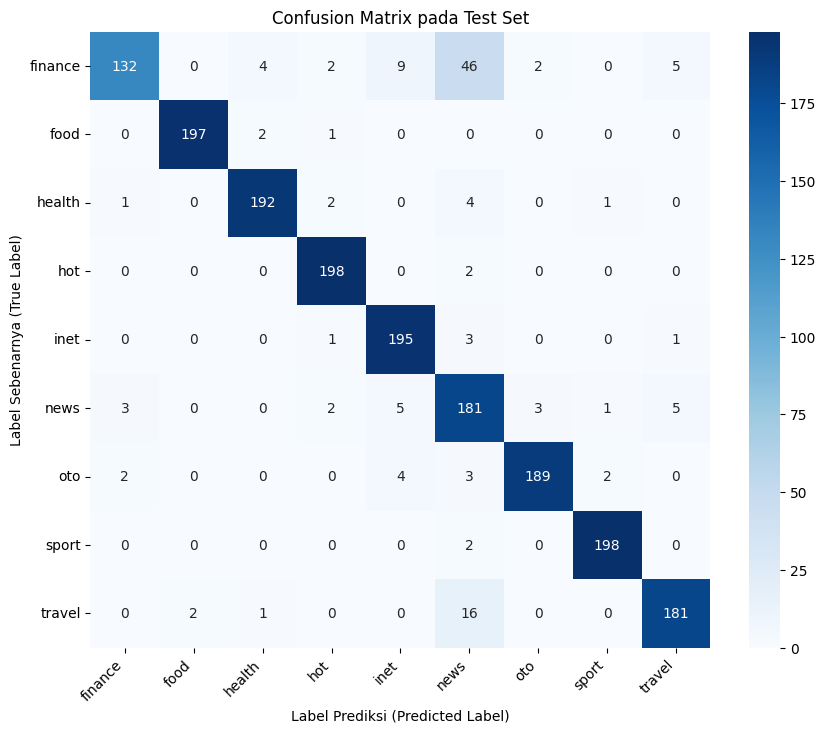

--------------------------------------------------


In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- VISUALISASI CONFUSION MATRIX PADA TEST SET ---")

class_names = le.classes_

cm = confusion_matrix(Y_true_int, Y_pred_int)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix pada Test Set')
plt.ylabel('Label Sebenarnya (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

print("--------------------------------------------------")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')